In [1]:
import time 
import os 

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from PIL import Image
from omegaconf import DictConfig, OmegaConf

import torch 
import torch.nn as nn 
import torchvision.transforms.functional as TF
import albumentations as A

from models.unet import UNET
from models.model import UNet

In [2]:
#cfg = OmegaConf.load('./cfg/default.yaml')
#model = UNET(cfg, mode='train')

model = UNet(input_filters=3,
            filters=64,
            N=2)

model = model.cuda()
model = nn.DataParallel(model)


checkpoint = "./backup/mall_mobilenetV2_UNET.pth"
model.load_state_dict(torch.load(checkpoint))

model.eval()

DataParallel(
  (module): UNet(
    (block1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (block2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

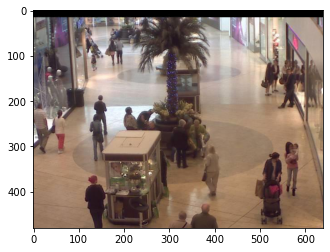

In [3]:
image_path = "../Dataset/mall_dataset/frames/seq_000001.jpg"
img = Image.open(image_path)

plt.imshow(img)
plt.show()

In [4]:
tensor_img = TF.to_tensor(img).unsqueeze_(0) # (3, H, W) -> (1, 3, H, W)
print(tensor_img.size())

torch.Size([1, 3, 480, 640])


In [5]:
start = time.time()

density_map = model(tensor_img)
end = time.time() 
print(density_map.size())
print(f"FPS: {1/(end-start)}")

torch.Size([1, 1, 480, 640])
FPS: 0.23819345460707658


In [6]:
# note: density maps were normalized to 100 * no. of objects
n_objects = torch.sum(density_map).item() / 100

print(f"The number of objects found: {n_objects}")

The number of objects found: -1686.8890625


## Visualize 

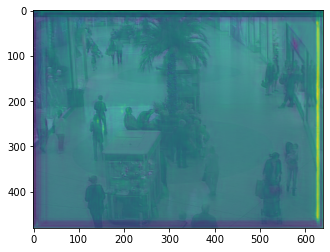

In [7]:
dmap = density_map.squeeze().cpu().detach().numpy()

plt.imshow(img)
plt.imshow(dmap, alpha=0.8)
plt.show()

In [8]:
from torchsummary import summary

In [9]:
summary(model, (3, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 640]           1,728
       BatchNorm2d-2         [-1, 64, 480, 640]             128
              ReLU-3         [-1, 64, 480, 640]               0
            Conv2d-4         [-1, 64, 480, 640]          36,864
       BatchNorm2d-5         [-1, 64, 480, 640]             128
              ReLU-6         [-1, 64, 480, 640]               0
            Conv2d-7         [-1, 64, 240, 320]          36,864
       BatchNorm2d-8         [-1, 64, 240, 320]             128
            Conv2d-9         [-1, 64, 480, 640]           1,728
             ReLU-10         [-1, 64, 240, 320]               0
      BatchNorm2d-11         [-1, 64, 480, 640]             128
           Conv2d-12         [-1, 64, 240, 320]          36,864
             ReLU-13         [-1, 64, 480, 640]               0
      BatchNorm2d-14         [-1, 64, 2

In [10]:
# (ref) https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {pytorch_total_params}')

Total number of trainable parameters: 593408
